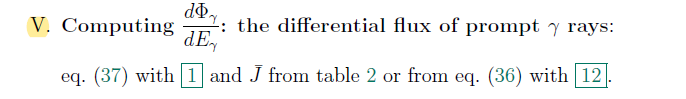

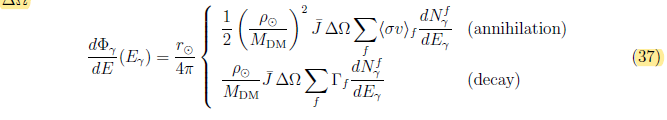
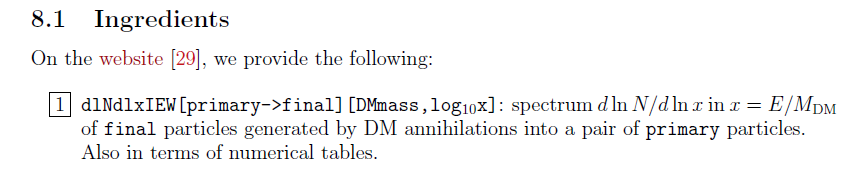


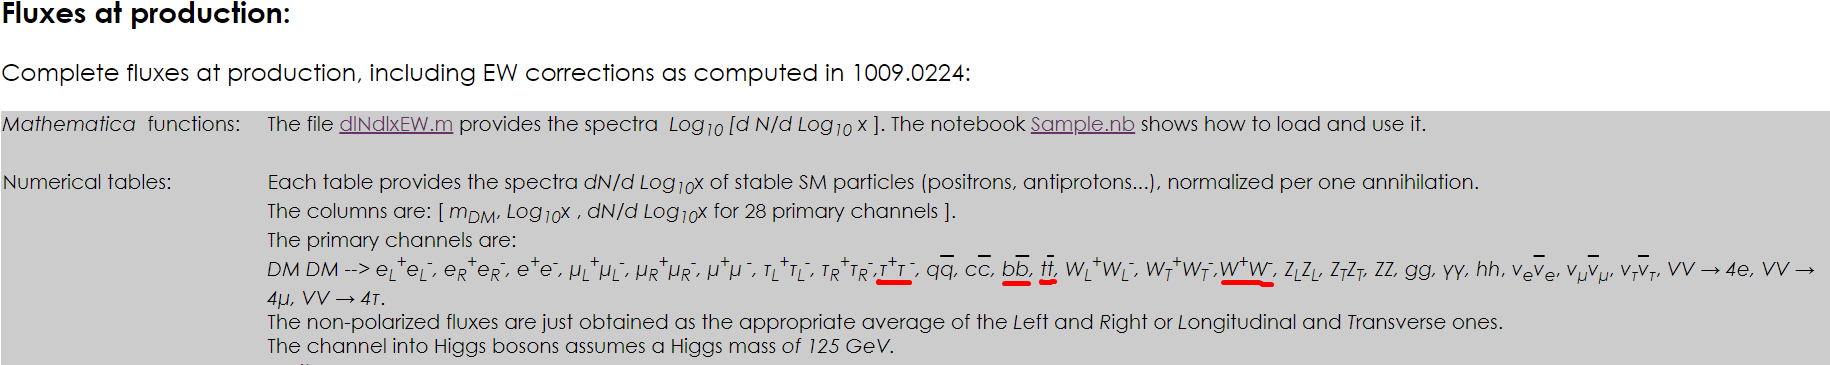

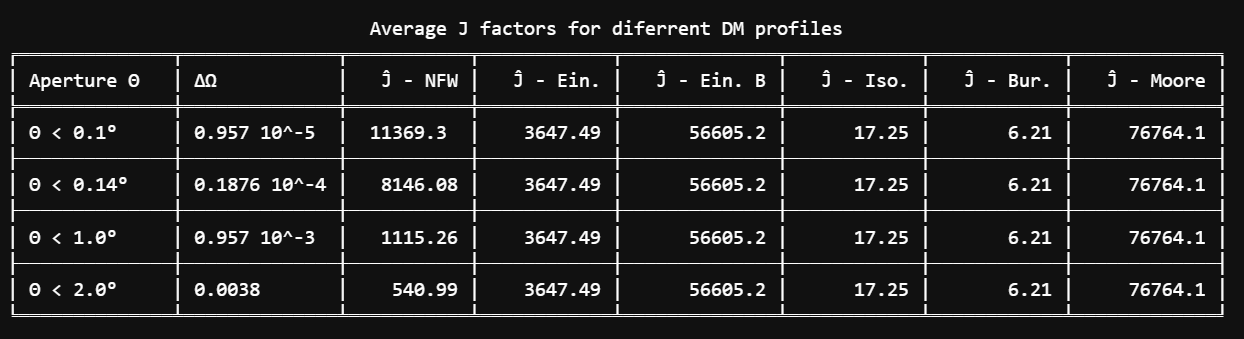

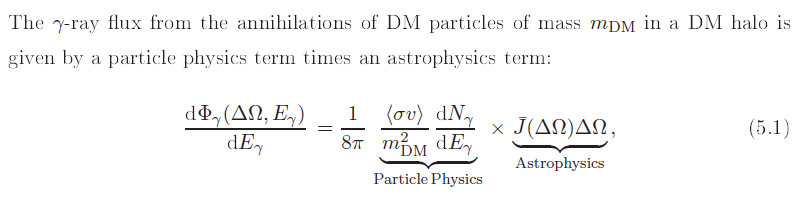

## Astrophysics term
### Average J factors for NFW density profile

In [1]:
from astropy.table import QTable, Table, Column
from astropy import units as u
import scipy
import scipy.integrate

class Average_J:
    def __init__(self, r_s, rho_s, profile): #, alpha, min, max, category):
        self.r_s = r_s
        self.rho_s = rho_s
        self._r_sun = 8.33 # kpc
        self._rho_sun = 0.3 # GeV/cm^3
        self.profile = profile
        #self.alpha = alpha#
        #self.min = min#
        #self.max = max#
        #self.category = category#
      
    def average(self, a, b): # ****************
        f = lambda theta: (2*np.pi)*(1/self.delta_omega(a, b))*(self.j_factor(theta, "annihilation")[0])*np.sin(theta)
        expr, err = scipy.integrate.quad(f, a, b)
        '''if self.category == "disk":
          f = lambda theta: (2*np.pi)*(1/self.delta_omega())*(self.j_factor(theta, "annihilation")[0])*np.sin(theta)
          expr, err = scipy.integrate.quad(f, a, b)
        elif self.category == "annulus":
          f = lambda theta: (2*np.pi)*(1/self.delta_omega())*(self.j_factor(theta, "annihilation")[0])*np.sin(theta)
          expr, err = scipy.integrate.quad(f, a, b)'''
        return expr

    #def BL_region(b):
      #  expr = lambda l, b: 4*np.cos(b)
      #  omega, err = dblquad(expr, [self.b_min, self.b_max], [self.l_min, self.l_max])
      #  return omega, err

    def delta_omega(self, minimum, maximum): # ****************
        expr, err = scipy.integrate.quad(lambda theta: 2*np.pi*np.sin(theta), minimum, maximum)
        '''if self.category == "disk":
          expr, err = integrate.quad(lambda theta: 2*np.pi*np.sin(theta), 0, self.max)
        elif self.category == "annulus":
          expr, err = integrate.quad(lambda theta: 2*np.pi*np.sin(theta), self.min, self.max)'''
        return expr

    def j_factor(self, theta, factor_type, **kwargs):
        """J-factor integral on the observer l.o.s.        
        :param theta: angle between GC and the observer line of sight (los).
        :param factor_type: j-factor type: annihilation or decay.
        :param *args: scipy integrate.quad arugments
        :return: integrated annihilation J-factor on los.
        """
        if factor_type == "annihilation":
            expr = lambda s: (1/self._r_sun)*(self.density(s, theta, geocentric=True)/self._rho_sun)**2
        elif factor_type == "decay":
            expr = lambda s: (1/self._r_sun)*(self.density(s, theta, geocentric=True)/self._rho_sun)
        j_factor, err = scipy.integrate.quad(expr, 0, np.inf, **kwargs)
        return j_factor, err

    def j_factor_map(self, L_coord, B_coord, delta_l, delta_b, factor_type='annihilation', **kwargs):
        """Bidimensional map of J-factors. 
        
        :param L_coord: grid of galactic polar longitudes.
        :param B_coord: grid of galactic polar latitudes.
        :param delta_l: spacing of galactic polar longitudes.
        :param delta_b: spacing of galactic polar longitudes.
        :param factor_type: j-factor type: annihilation or decay.
        :return: integrated j_factor at each grid position.
        """
        #factors = np.zeros_like(L_coord)
        factors = np.zeros(len(B_coord), len(L_coord))
        
        for i in range(L_coord.shape[0]):
            for j in range(B_coord.shape[0]):
                l, b = L_coord[i], B_coord[j]
                theta = np.arccos(np.cos(l)*np.cos(b))
                aperture = delta_l*(np.sin(B_coord[i, j]+delta_b/2) - np.sin(B_coord[i, j]-delta_b/2))
                factors[j, i] = aperture*self.j_factor(theta, factor_type, **kwargs)[0] 
        return factors

    def apertures_map(self, L_coord, B_coord, delta_l, delta_b):
        """Bidimensional map of apertures. All angles should be
        in rad.
        
        :param L_coord: grid of galactic polar longitudes.
        :param B_coord: grid of galactic polar latitudes.
        :param delta_l: spacing of galactic polar longitudes.
        :param delta_b: spacing of galactic polar longitudes.
        :return: apertures at each grid cell.
        """
        apertures = np.zeros_like(L_coord)
        
        for i in range(L_coord.shape[0]):
            for j in range(B_coord.shape[0]):
                aperture = delta_l*(np.sin(B_coord[i, j]+delta_b/2) - np.sin(B_coord[i, j]-delta_b/2))
                apertures[i, j] = aperture
        return apertures

    def _geocentric_to_galactocentric(self, s, theta):
        """Convert between geocentric and galactocentric distances. 

        :param r: galactocentric distance.
        :param theta: geocentric angle positive from the GC.
        """
        return np.sqrt(self._r_sun**2 + s**2 - 2*s*self._r_sun*np.cos(theta))
    
    def density(self, r, theta=None, geocentric=False):
        p = 0
        if geocentric:
            r = self._geocentric_to_galactocentric(r, theta)
        #return self.rho_s/((r/self.r_s)*(1+r/self.r_s)**2)
        if self.profile == "NFW":
            #p = self.rho_s/((r/self.r_s)*(1+r/self.r_s)**2)
            r_s=24.42
            rho_s=0.184
            p = rho_s/((r/r_s)*(1+r/r_s)**2)
        
        elif self.profile == "Einasto":
            #p = self.rho_s * np.exp(-2/self.alpha*((r/self.r_s)**self.alpha-1))
            r_s=28.44
            rho_s=0.033
            alpha=0.17
            p = rho_s * np.exp(-2/alpha*((r/r_s)**alpha -1))        
        elif self.profile == "Moore":
            #p = self.rho_s*(self.r_s/r)**(1.16) * (1 + r/self.r_s)**(-1.84)
            r_s=30.28
            rho_s=0.105
            p = self.rho_s*(self.r_s/r)**(1.16) * (1 + r/self.r_s)**(-1.84)
        return p


In [2]:
from tabulate import tabulate
import numpy as np

rs = [24.42, 28.44, 35.24, 4.38, 12.67, 30.28]
ps = [0.184, 0.033, 0.021, 1.387, 0.712, 0.105]
profile = ["NFW"]
limits = np.array([0.1, 0.14, 1, 2])*np.pi/180 # degrees -> radius
theta_min = 0
omega_disk, omega_annulus = np.zeros(len(limits)), np.zeros(len(limits))
J_average_disk, J_average_annulus = np.zeros([len(limits), len(profile)]), np.zeros([len(limits), len(profile)])

# Disk
for j in range(0, len(profile)):
    for i in range(0, len(limits)):
        #a = Average_J(rs[j], ps[j], profile[j], alpha[j], theta_min, limits[i], "disk")
        a = Average_J(rs[j], ps[j], profile[j])
        omega_disk[i] = a.delta_omega(theta_min, limits[i])
        J_average_disk[i][j] = a.average(0, limits[i])

print(J_average_disk)


/tmp/ipykernel_210/194898380.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  j_factor, err = scipy.integrate.quad(expr, 0, np.inf, **kwargs)
/tmp/ipykernel_210/194898380.py:53: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  j_factor, err = scipy.integrate.quad(expr, 0, np.inf, **kwargs)
/tmp/ipykernel_210/194898380.py:53: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  j_factor, err = scipy.integrate.quad(expr, 0, np.inf, **k

[[11369.32648679]
 [ 8146.0779262 ]
 [ 1115.25578814]
 [  540.98694202]]


In [3]:
columns = ['Aperture Θ', 'ΔΩ', 'Ĵ - NFW']
limits = limits*180/np.pi
J_average_disk = np.around(J_average_disk, 2)
#J_average_annulus = np.around(J_average_annulus, 2)

#print('Disk:\n DeltaOmega:\n', np.around(omega_disk, 7), '\n\nJ:\n', J_average_disk, '\n\n')
t_disk = [columns,
          ['Θ < '+str(limits[0])+'°', str(np.around(omega_disk[0]*(1e5), 4))+' x 10^-5', J_average_disk[0,0]],#, J_average_disk[0,1], J_average_disk[0,2], J_average_disk[0,3], J_average_disk[0,4], J_average_disk[0,5]],
          ['Θ < '+str(limits[1])+'°', str(np.around(omega_disk[1]*(1e4), 4))+' x 10^-4', J_average_disk[1,0]],
          ['Θ < '+str(limits[2])+'°', str(np.around(omega_disk[2]*(1e3), 4))+' x 10^-3', J_average_disk[2,0]],
          ['Θ < '+str(limits[3])+'°', np.around(omega_disk[3], 4), J_average_disk[3,0]]
        ]

print('\n\t Average J factors for NFW density profile')
print(tabulate(t_disk, headers='firstrow', tablefmt='fancy_grid'))


	 Average J factors for NFW density profile
╒══════════════╤════════════════╤═══════════╕
│ Aperture Θ   │ ΔΩ             │   Ĵ - NFW │
╞══════════════╪════════════════╪═══════════╡
│ Θ < 0.1°     │ 0.957 x 10^-5  │  11369.3  │
├──────────────┼────────────────┼───────────┤
│ Θ < 0.14°    │ 0.1876 x 10^-4 │   8146.08 │
├──────────────┼────────────────┼───────────┤
│ Θ < 1.0°     │ 0.957 x 10^-3  │   1115.26 │
├──────────────┼────────────────┼───────────┤
│ Θ < 2.0°     │ 0.0038         │    540.99 │
╘══════════════╧════════════════╧═══════════╛


## Partcile Physics term and gamma-ray flux
< sigmaV >: 3x10^-26 cm^3s^-1

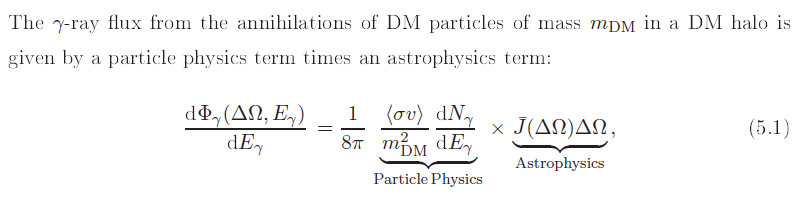

In [4]:
import numpy as np

def flux(mDM, dNdE, Ĵ, delta_omega, channel):
    sigmav = 3*(1e-26)
    PP = sigmav*dNdE/(mDM**2)
    Astro = Ĵ*delta_omega
    flux = PP*Astro/(8*(np.pi))
    return flux, channel

In [5]:
# importing the fluxes dN/dLog10x
import numpy as np
import pandas as pd
import csv

rows = pd.read_csv('espectros diferenciais/AtProduction_gammas/AtProduction_gammas(1).txt', skiprows=[0], header = None, sep=" ")
rows.columns = ["mDM", "Log10(x)", "eL+eL-", "eR+eR-", "e+e-", "μL+μL-", "μR+μR-", "μ+μ-", "τL+τL-", "τR+τR-", "ττ", "qq", "cc", "bb", "tt", "WL+WL-", "WT+WT-", "WW", "ZLZL", "ZTZT", "ZZ", "gg", "γγ", "hh", "νeνe", "νμνμ", "ντντ", "VV > 4e", "VV > 4μ", "VV > 4τ"]
data = rows.to_numpy() 
mDM = data[:,0]
logx = data[:,1]
E = np.zeros(len(logx))

for i in range(0, len(E)):
    E[i] = mDM[i]*(10**logx[i])

rows.insert(2, "E", E, True)
data = rows.to_numpy() # dataframe to numpy array

dNdLogx_bbar = rows.bb.to_numpy()
dNdLogx_ttar = rows.tt.to_numpy()
dNdLogx_ττ = rows.ττ.to_numpy()
dNdLogx_WW = rows.WW.to_numpy()

rows

,mDM,Log10(x),E,eL+eL-,eR+eR-,e+e-,μL+μL-,μR+μR-,μ+μ-,τL+τL-,...,ZZ,gg,γγ,hh,νeνe,νμνμ,ντντ,VV > 4e,VV > 4μ,VV > 4τ
0,10,-8.90,1.258925e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,10,-8.85,1.412538e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,10,-8.80,1.584893e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,10,-8.75,1.778279e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,10,-8.70,1.995262e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,1000,-0.20,6.309573e+02,0.154852,0.159638,0.157245,0.103079,0.106250,0.104664,0.287417,...,0.015466,0.049312,0.003915,0.023070,0.002571,0.001664,0.002401,0.049568,0.007253,0.016084
712,1000,-0.15,7.079458e+02,0.147174,0.151776,0.149475,0.096756,0.099775,0.098265,0.194036,...,0.009105,0.027360,0.004223,0.020744,0.001942,0.001244,0.001418,0.037050,0.004981,0.006714
713,1000,-0.10,7.943282e+02,0.138862,0.143256,0.141059,0.090446,0.093305,0.091876,0.126409,...,0.005000,0.014487,0.050059,0.020221,0.001135,0.000724,0.000681,0.025530,0.003149,0.002627
714,1000,-0.05,8.912509e+02,0.130158,0.134331,0.132244,0.083708,0.086391,0.085049,0.085098,...,0.002446,0.007846,2.740151,0.020099,0.000064,0.000048,0.000043,0.015730,0.001788,0.000973


In [9]:
print(rows.columns)

Index(['mDM', 'Log10(x)', 'E', 'eL+eL-', 'eR+eR-', 'e+e-', 'μL+μL-', 'μR+μR-',
       'μ+μ-', 'τL+τL-', 'τR+τR-', 'ττ', 'qq', 'cc', 'bb', 'tt', 'WL+WL-',
       'WT+WT-', 'WW', 'ZLZL', 'ZTZT', 'ZZ', 'gg', 'γγ', 'hh', 'νeνe', 'νμνμ',
       'ντντ', 'VV > 4e', 'VV > 4μ', 'VV > 4τ'],
      dtype='object')


In [6]:
#rows.mDM[400]
seen = set()
uniq_mDM = [x for x in rows.mDM if x not in seen and not seen.add(x)]
uniq_mDM #uniq values of mass

[10, 100, 500, 1000]

### dN/dE x dN/dLog(x)

We know that:
```
x = E/mDM
=> E = mDM x 10^(Log(x))
```

The Gamma-ray Flux equation consider dN/dE, and not dN/dLog(x). In the calculations above, 'dN/dLog(x)' was assumed to be 'dN/dE', which is an incorret assumption.

In [10]:
# We have 4 values for ΔΩ and Ĵ, and 716 values of Energy.
# This code generates 4 different tables, one for each value of Ĵ and ΔΩ.
# The Gamma-ray flux is calculated according to the corresponding channel.

#columns = ['ΔΩ', 'Ĵ - NFW', "mDM", "E", "dN/dLog10(x)", "dΦ/dE"]
columns = ["mDM (GeV)", "E", "Log10(x)", "dΦ/dE(bbar)", "dΦ/dE(ttar)", "dΦ/dE(τ+τ-)", "dΦ/dE(W+W-)"]
channels = ["bbar", "ttbar", "τ+τ-", "W+W-"]

flux_bb = np.zeros(len(mDM))
flux_tt = np.zeros(len(mDM))
flux_ττ = np.zeros(len(mDM))
flux_WW = np.zeros(len(mDM))

#flux(mDM, dNdE, Ĵ, delta_omega, channel)
for j in range(0, len(J_average_disk)):
    print('\t\t Gamma-ray Flux for Ĵ =', J_average_disk[j], 'and ΔΩ =', np.around(omega_disk[j], 9),'(',j+1,')\n')
    for i in range(0, len(mDM)):
        flux_bb[i] = flux(mDM[i], dNdLogx_bbar[i], J_average_disk[j], omega_disk[j], "bbar")[0]
        flux_tt[i] = flux(mDM[i], dNdLogx_ttar[i], J_average_disk[j], omega_disk[j], "ttar")[0]
        flux_ττ[i] = flux(mDM[i], dNdLogx_ττ[i], J_average_disk[j], omega_disk[j], "τ+τ-")[0]
        flux_WW[i] = flux(mDM[i], dNdLogx_WW[i], J_average_disk[j], omega_disk[j], "W+W-")[0]
    
    table = np.column_stack((mDM, E, logx, flux_bb, flux_tt, flux_ττ, flux_WW))
    table_final = pd.DataFrame(table, columns = columns)
    #print(table_final)
    print(tabulate(table_final, headers=columns, tablefmt='fancy_grid'),'\n\n\n')


		 Gamma-ray Flux for Ĵ = [11369.33] and ΔΩ = 9.57e-06 ( 1 )

╒═════╤═════════════╤════════════════╤════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│     │   mDM (GeV) │              E │   Log10(x) │   dΦ/dE(bbar) │   dΦ/dE(ttar) │   dΦ/dE(τ+τ-) │   dΦ/dE(W+W-) │
╞═════╪═════════════╪════════════════╪════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│   0 │          10 │    1.25893e-08 │      -8.9  │   0           │   0           │   0           │   0           │
├─────┼─────────────┼────────────────┼────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│   1 │          10 │    1.41254e-08 │      -8.85 │   0           │   0           │   0           │   0           │
├─────┼─────────────┼────────────────┼────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│   2 │          10 │    1.58489e-08 │      -8.8  │   0           │   0           │   0           │   0           │
├─────┼───